### This exercise we'll be used to preditict who in Africa is most likely to have a bank account?

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Import packages
import pandas as pd
from glob import glob
import os
from pathlib import Path
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 

from category_encoders import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


import pickle

In [2]:
# Import datasets
def import_datasets(woking_dir):
    df_dict = {}
    csv_files =  glob("*csv")
    for file in csv_files:
        file_name =file.split('.')[0]
        print(file_name)
        df = pd.read_csv(file)
        df_dict[file_name] = df
    return df_dict
# call function
df_dict = import_datasets(os.getcwd())
train_df = df_dict['Train']
test_df = df_dict['Train']

SampleSubmission
Submission
Test
Train
VariableDefinitions


### Lets have a look at the data EDA

In [3]:
train_df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [5]:
train_df.nunique()

country                      4
year                         3
uniqueid                  8735
bank_account                 2
location_type                2
cellphone_access             2
household_size              20
age_of_respondent           85
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

#### From the above cell we can see that the unique_id column has very high cardinality thus it's likely to be a skew our prediction we'll have to drop it

bank_account
No     85.92
Yes    14.08
Name: proportion, dtype: float64


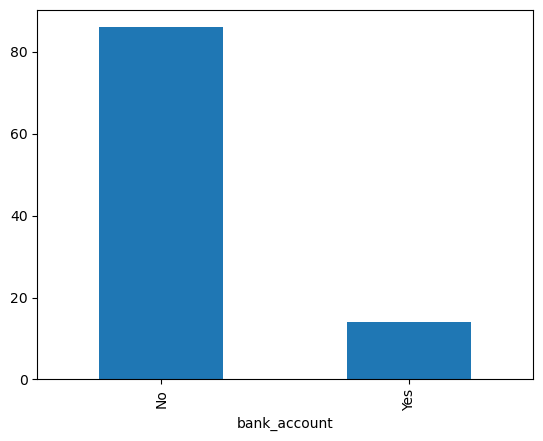

In [6]:
## Have a look at the data distribution of the target variable
print((train_df['bank_account'].value_counts(normalize = True)*100).round(2))
(train_df['bank_account'].value_counts(normalize = True)*100).plot(kind ='bar');

#### From the above plot we can see that only 14% of the population has access to a bank account where as the other 86% of the population has no access to a bank account.

In [7]:
# Lets explore year data, see if it has much influence on the target variable
# Logically it wouldn't have much influence
print(f'Year counts {train_df["year"].value_counts()}, \n\nyear percentage representation {train_df["year"].value_counts(normalize=True)*100}')

train_df_encoded = pd.get_dummies(train_df, columns=['bank_account']).rename(columns={'bank_account_Yes': 'bank_account_No_encoded'})

#Calculate correlation with one of the one-hot encoded 
print(f'\nThe correlation between year and having a bank accountis {train_df["year"].corr(train_df_encoded["bank_account_No_encoded"]):.3f}')


Year counts year
2016    8735
2018    8169
2017    6620
Name: count, dtype: int64, 

year percentage representation year
2016    37.132290
2018    34.726237
2017    28.141473
Name: proportion, dtype: float64

The correlation between year and having a bank accountis 0.112


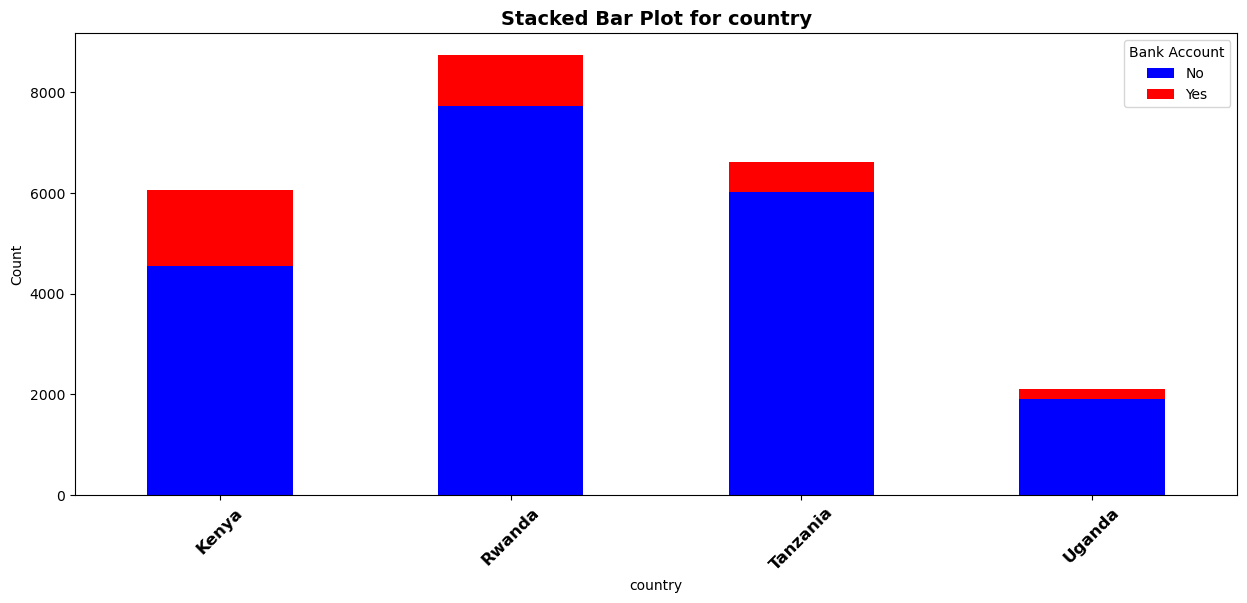

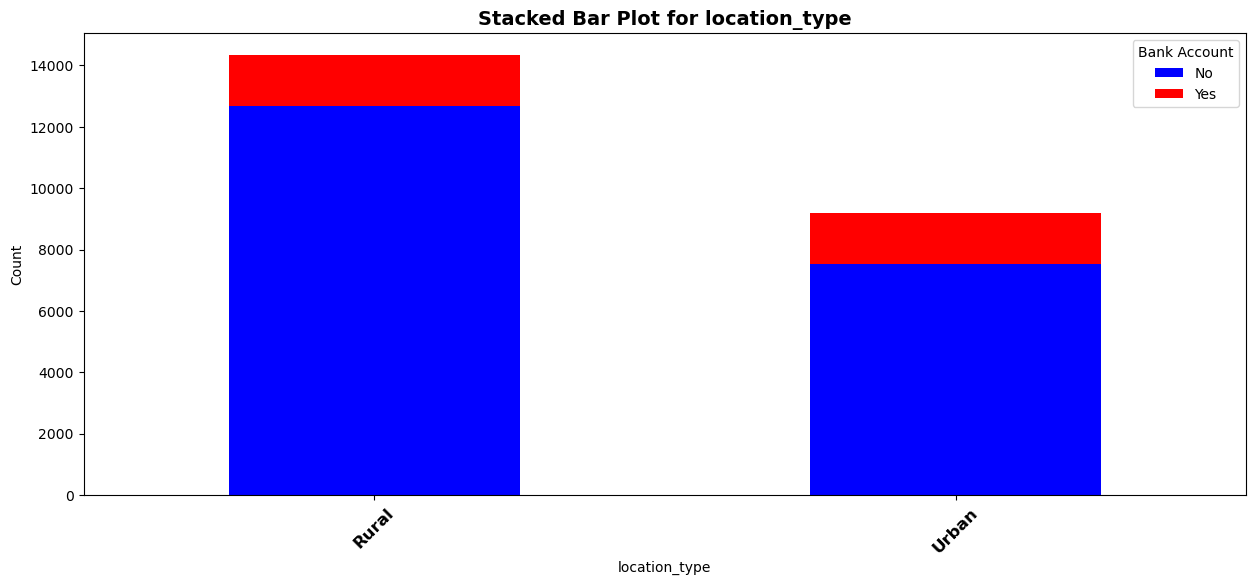

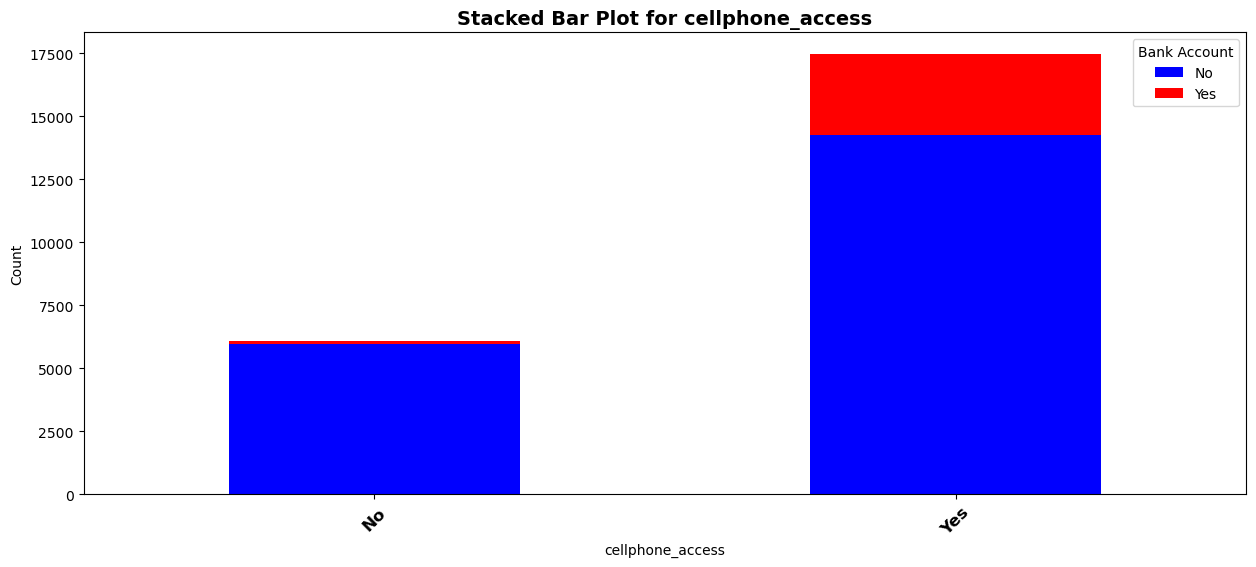

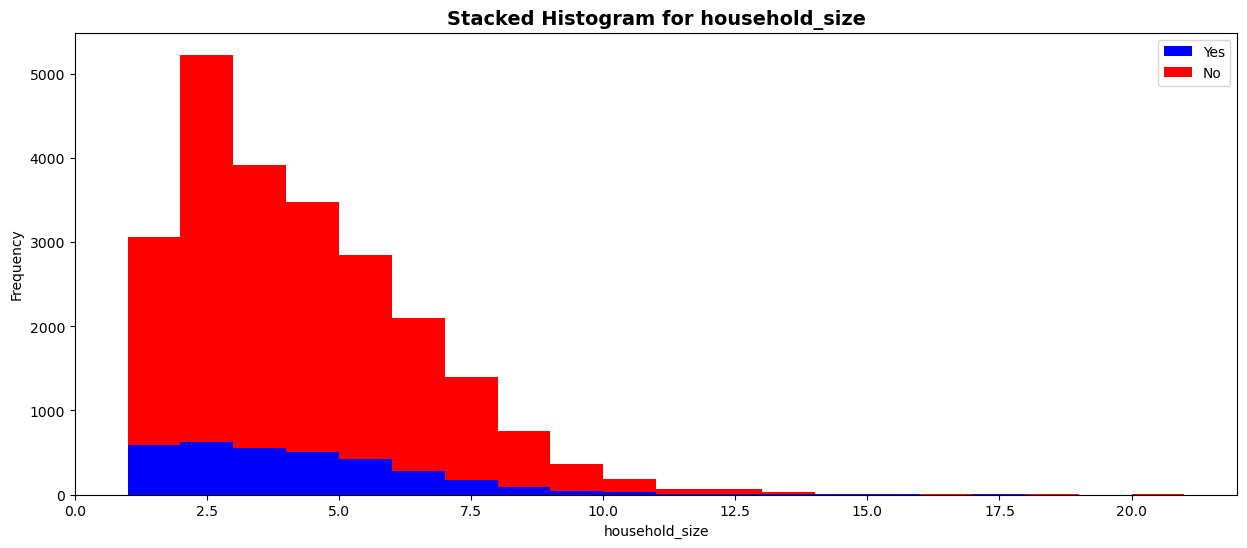

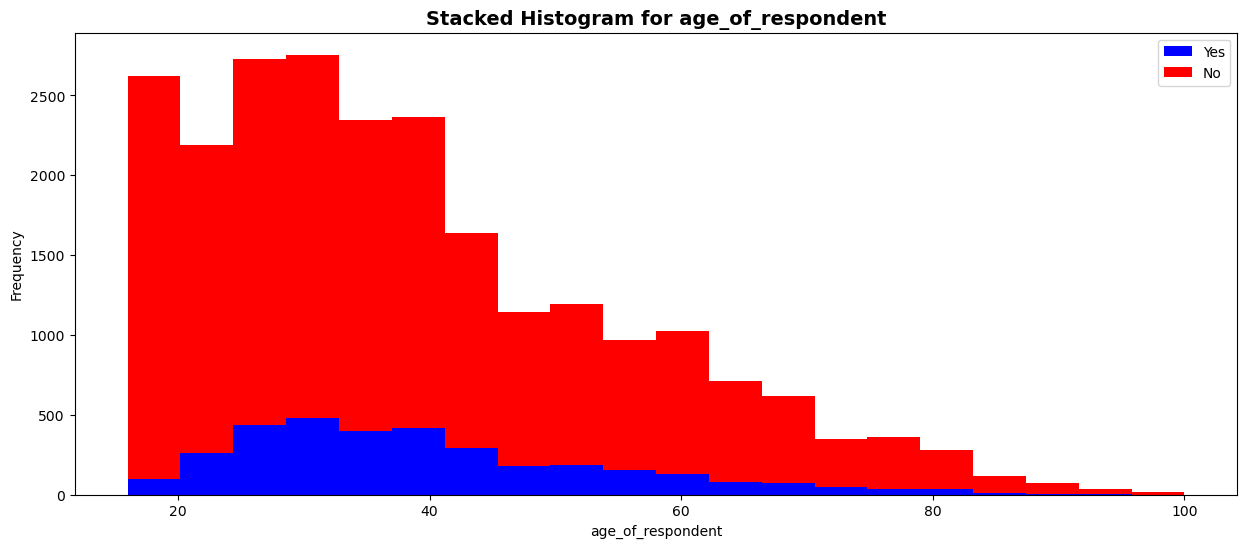

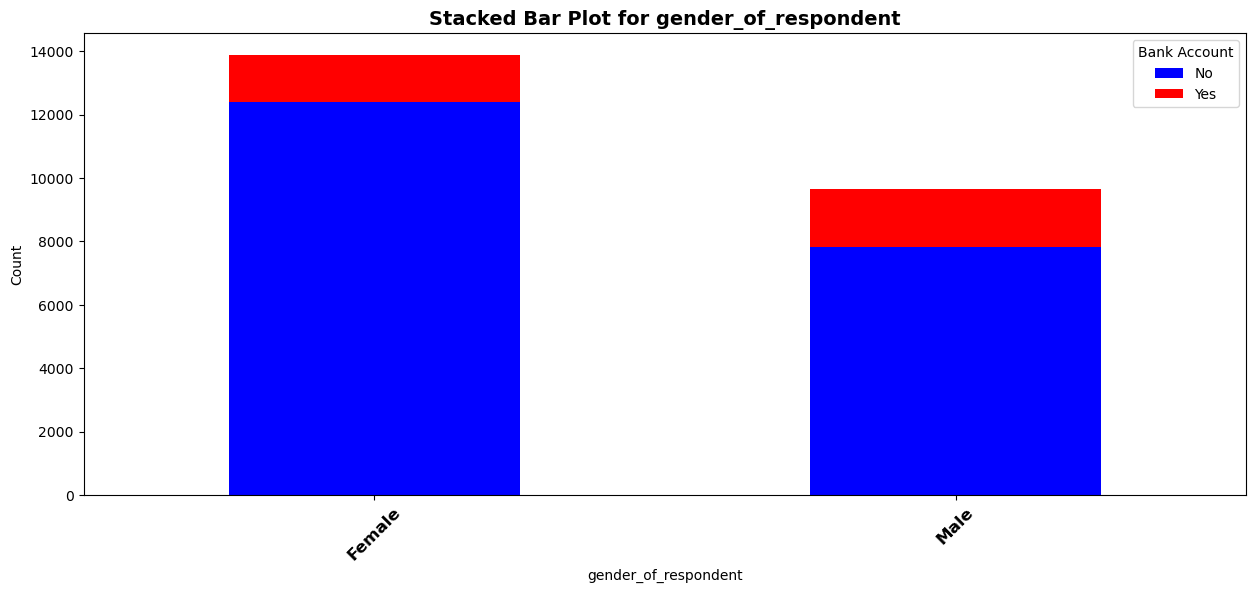

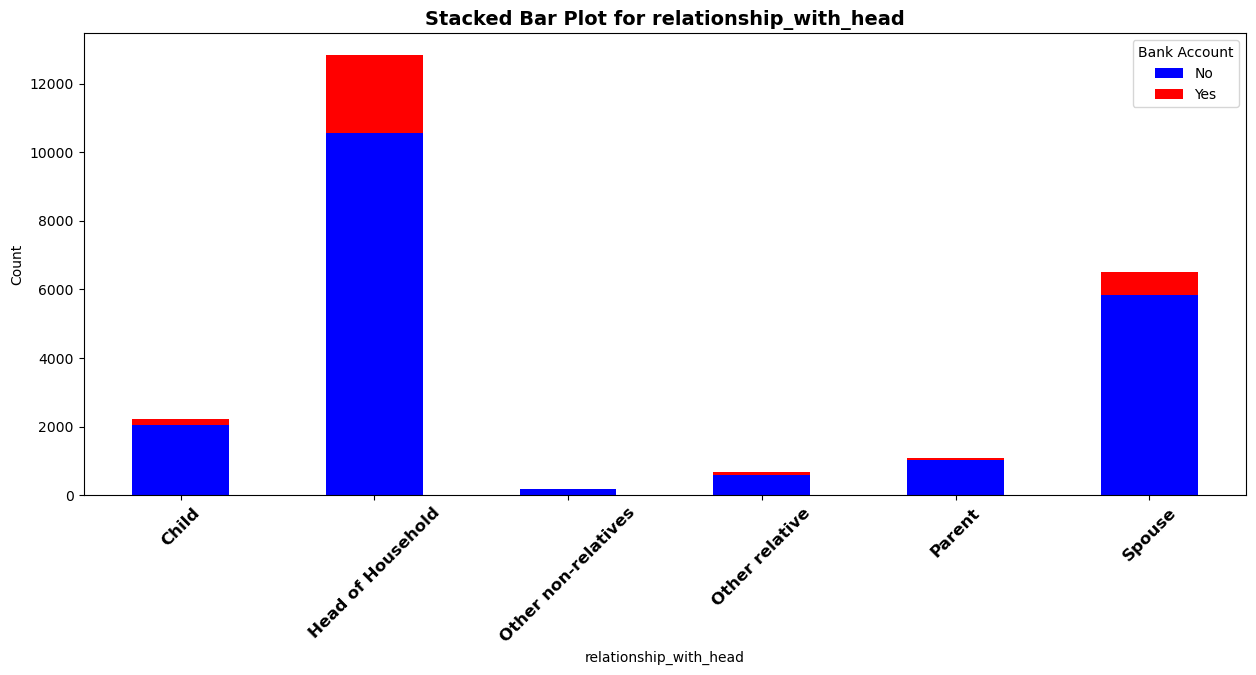

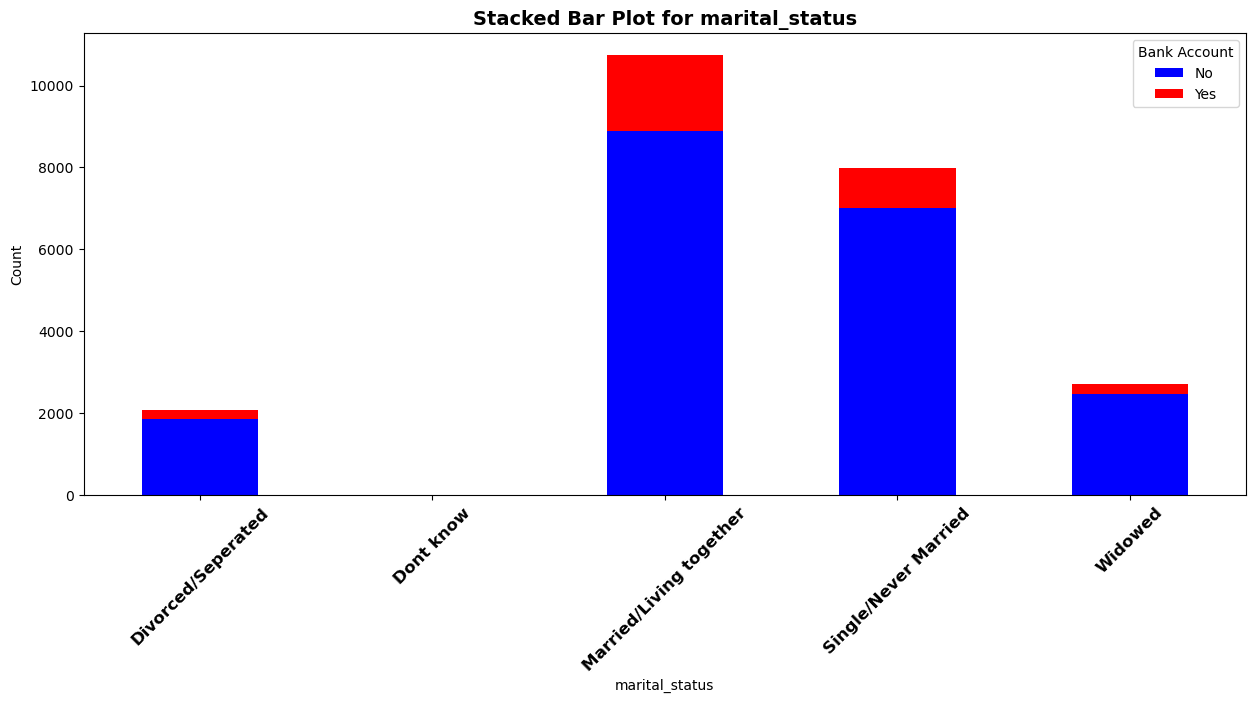

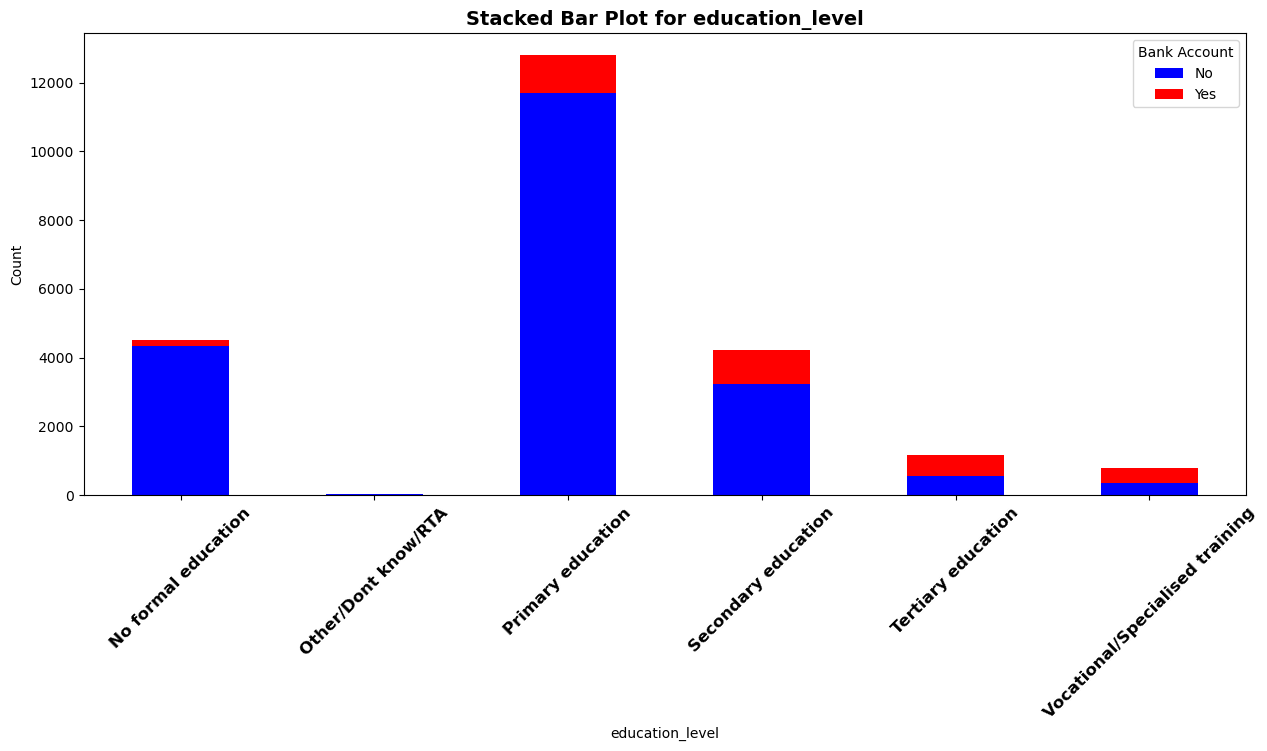

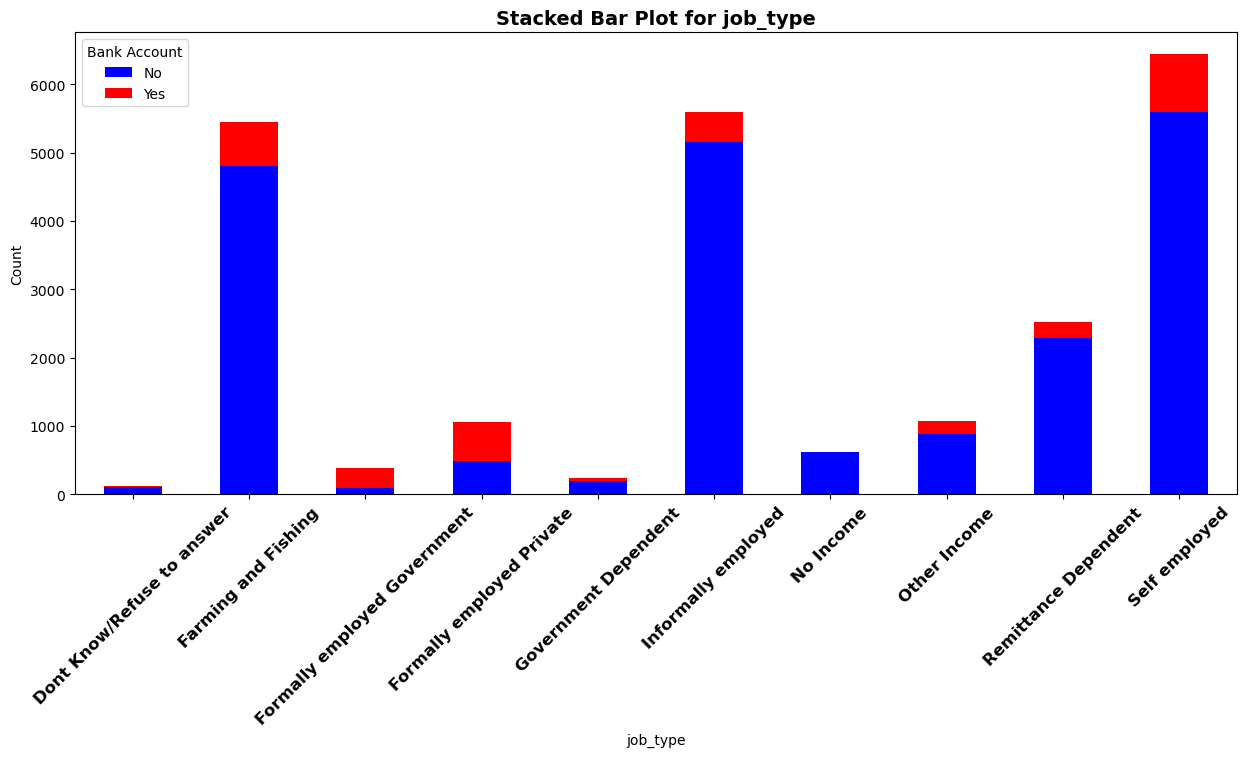

In [8]:
# plot stacked histogram
def stacked_plots(df):

    # Get column with integer data type
    int_cols = df.select_dtypes(include=['int64']).columns

    for col in df.columns:
        # Exclude bank_account since it's the target variable and uniqueid due to high cardinality
        if col != 'bank_account' and col != 'uniqueid' and col != 'year': 
            pair_df = df.loc[:, [col, 'bank_account']]
            

            if col in int_cols:
                has_bank_account = pair_df[pair_df['bank_account'] == "Yes"][col]
                no_banks_account = pair_df[pair_df['bank_account'] == "No"][col]
                
                # Plot stacked histogram
                plt.figure(figsize=(15, 6))
                plt.hist([has_bank_account, no_banks_account], bins=20, label=['Yes', 'No'], color=['blue', 'red'], stacked= True)
                plt.xlabel(f'{col}')
                plt.ylabel("Frequency")
                plt.title(f'Stacked Histogram for {col}',fontsize = 14, weight = "bold")
                plt.legend()
                plt.ticklabel_format(style='plain', axis='x')
                plt.show()
                
            # Plot stacked bar chart for columns with non-integer data types
            else:

                # Convert bank_account to categorical type for proper plotting
                pair_df['bank_account'] = pair_df['bank_account'].astype('category')
       
                ax = pair_df.groupby([col])['bank_account'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(15, 6), color=['blue', 'red'])
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.title(f'Stacked Bar Plot for {col}', fontsize = 14, weight = "bold")
                plt.xticks(rotation=45, fontsize=12, weight = "bold")
                plt.legend(title='Bank Account', loc='best')
                
                # Annotate each bar
                # for container in ax.containers:
                # ax.bar_label(container, label_type='center', color='white', fmt='%.1f', fontsize=14)
                
                plt.show()
        
stacked_plots(train_df)

From the above plots we could see that
    
    1.The are more people with bank accounts ins Kenya than any other country, Uganda has the least amount of people woth bank accoumts however the sample sixe from Uganda is also significantly small.

    2.Date values are represented as object however there is no distinct feature, we cam derive from this.

    3.A huge part of the survey was done in the rural area but the number of people in both urbana and rural seem fairly the same

    4.People with bank account are more likely to have bank account

    5.Male individuals are alse more likely to have bank accounts

    6.The head of the household is also likely to have a bank account unlike other family members

    7.People who are married and living together are also likely to have bank accounts

    8.Educated poeple are also likely to have bank account unlike those that are less educated.

    9.Government dependent and people with no income are less likely to have bank accounts.

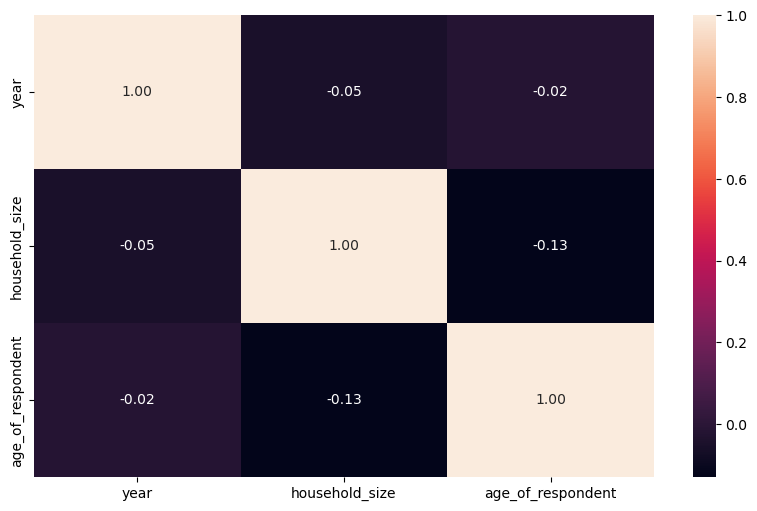

In [9]:
# Check for multicoliniearity
plt.figure(figsize=(10, 6))
correlation = train_df.select_dtypes('number').corr()
sns.heatmap(correlation, annot=True, fmt=".2f");

##### From the above correlation plot we've seen we have no multicollinearity

In [10]:
# Create a baseline model. which we'll tune our model on and try to beat.
print(f'Our baseline model score is {(max(train_df["bank_account"].value_counts(normalize = True)))*100:.2f}%')

Our baseline model score is 85.92%


#### Prepare data for modeling

In [11]:
# Extract 'uniqueid' column since we are going to use it in our submission
uniqueid = train_df['uniqueid']

In [12]:
def wrangle(df):
    # droop column with high cardinality
    if 'uniqueid' in df.columns: 
        df.drop(columns = ['uniqueid'], inplace = True)
    # change date column from datetime or string to int in a scenario it's not and integer
    if isinstance(df['year'].iloc[0], (datetime.datetime, str)):
        df['year'] = df['year'].astype(int)
    
    #split the data into feature matrix and target vector
    target  = "bank_account"
    X = df.drop(columns = target, axis = 1)
    y = df[target]

    return X, y


def over_and_under_sample_data (X, y):
    #under sample the data due to impbalanced data
    under_sampler = RandomUnderSampler(random_state = 42)
    X_train_under, y_train_under = under_sampler.fit_resample(X, y)

    #over sample the data due to impbalanced data
    over_sampler = RandomOverSampler(random_state = 42)
    X_train_over, y_train_over = over_sampler.fit_resample(X, y)

    data_dict = {
        "under_sampled_data" : [X_train_under, y_train_under],
        'over_sampled_data' : [X_train_over, y_train_over]
    }

    return data_dict


def build_model(data_dict):
    # Create a classifier with a pipline of one hot encoding and a Random RandomForestClassifier model
    clf = make_pipeline(
        OneHotEncoder(),
        RandomForestClassifier(random_state = 42)
    )

    # Tune parameters to reduce computational cost
    params = {
    'randomforestclassifier__n_estimators': range(25, 100, 25) #we'll leave the rest of the parameters as default
    }
   # Create separate GridSearchCV for under-sampled and over-sampled data
    under_sampled_model = GridSearchCV(
        clf,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    over_sampled_model = GridSearchCV(
        clf,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    # Fit the models
    under_sampled_model.fit(data_dict.get('under_sampled_data')[0], data_dict.get('under_sampled_data')[1])
    over_sampled_model.fit(data_dict.get('over_sampled_data')[0], data_dict.get('over_sampled_data')[1])

    # retrieve best model
    under_sampled_best_model = under_sampled_model.best_estimator_
    over_sampled_best_model = over_sampled_model.best_estimator_
    
    model_dict = {
        'under_sampled_best_model': under_sampled_best_model,
        'over_sampled_best_model': over_sampled_best_model
    }
    
    print(f'\nBest perfoming undersampled model score {under_sampled_model.best_score_}\nBest estimator params {under_sampled_model.best_estimator_}')
    print(f'\nBest perfoming oversampled model score {over_sampled_model.best_score_}\nBest estimator params {over_sampled_model.best_estimator_}')
    
    return model_dict


def evaluate_model(data_dict, model_dict):
    # Extract data
    under_sampled_X = data_dict.get('under_sampled_data')[0]
    under_sampled_y = data_dict.get('under_sampled_data')[1]

    over_sampled_X = data_dict.get('over_sampled_data')[0]
    over_sampled_y = data_dict.get('over_sampled_data')[1]

    # Extract models
    under_sampled_model = model_dict.get('under_sampled_best_model')
    over_sampled_model = model_dict.get('over_sampled_best_model')

    # Cross-validation accuracy scores
    under_sampled_cv_acc_scores = cross_val_score(under_sampled_model, under_sampled_X, under_sampled_y, cv=5, n_jobs=-1)
    over_sampled_cv_acc_scores = cross_val_score(over_sampled_model, over_sampled_X, over_sampled_y, cv=5, n_jobs=-1)

    
    return {
        "under_sampled_cv_acc_scores": under_sampled_cv_acc_scores,
        "over_sampled_cv_acc_scores": over_sampled_cv_acc_scores
    }


In [13]:
# call functions
X, y = wrangle(train_df)

# under and oversample data
data_dict = over_and_under_sample_data(X, y)

# build model
model_dict = build_model(data_dict)

# Evaluate models
cross_validation_scores = evaluate_model(data_dict ,model_dict)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best perfoming undersampled model score 0.6782712192897452
Best estimator params Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['country', 'location_type',
                                     'cellphone_access', 'gender_of_respondent',
                                     'relationship_with_head', 'marital_status',
                                     'education_level', 'job_type'])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=75, random_state=42))])

Best perfoming oversampled model score 0.8292078751342199
Best estimator params Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['country', 'location_type',
                                     'cellphone_access', 'gender_of_respondent',
                                     'relationship_with_head', 'marital_status',
    

In [14]:
cross_validation_scores

{'under_sampled_cv_acc_scores': array([0.75622642, 0.73886792, 0.69056604, 0.65886792, 0.54682779]),
 'over_sampled_cv_acc_scores': array([0.68274583, 0.90599876, 0.90327767, 0.92566481, 0.7283523 ])}

In [15]:
test_df.columns

Index(['country', 'year', 'bank_account', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

In [16]:
# Lets check the test the accuracy of our models
# Extract models
under_sampled_model = model_dict.get('under_sampled_best_model')
over_sampled_model = model_dict.get('over_sampled_best_model')

X_test, y_test =  wrangle(test_df)
under_sampled_acc_test = under_sampled_model.score(X_test, y_test)
over_sampled_acc_test = over_sampled_model.score(X_test, y_test)

print(f'under_sampled_acc_test_score{under_sampled_acc_test}')
print(f'over_sampled_acc_test_score{over_sampled_acc_test}')

under_sampled_acc_test_score0.8138071756503996
over_sampled_acc_test_score0.9639091991157966


### Our oversampled df produces better results and it beats the baseline
#### However let's see it's precision and recall by performing ploting a confusion matrix


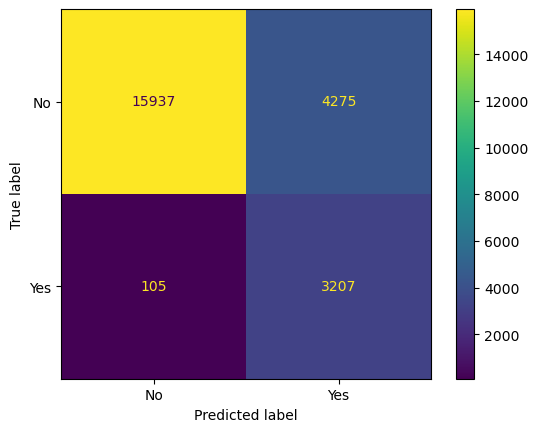

In [17]:
# Plot confusion matrix for  under sampled model
ConfusionMatrixDisplay.from_estimator(under_sampled_model, X_test, y_test);

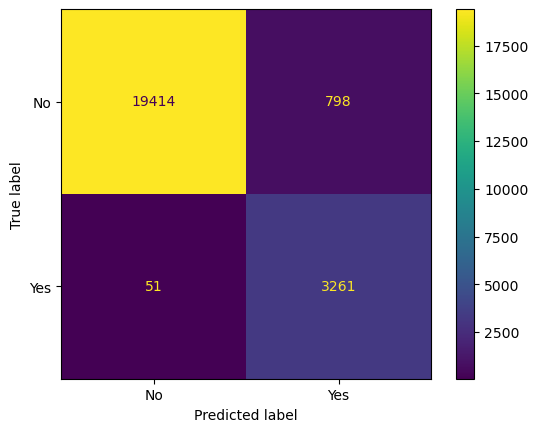

In [18]:
# Plot confusion matrix for  over sampled model
ConfusionMatrixDisplay.from_estimator(over_sampled_model, X_test, y_test);

### Our over sampled model is the best model since it has better predicts the people who are likely to have a bank account
### Further it gives better true negatives thus it predicts those that are less like to have a bank account better with less False Positives

In [19]:
# Extract predictions from model
predictions = over_sampled_model.predict(X_test)
Submission = pd.DataFrame({'unique_id': test_df.index, 'bank_account': predictions})


# Save DataFrame to CSV
Submission.to_csv('Submission.csv', index=False)

# Save model
with open('model.pkl', 'wb') as f:
    pickle.dump(over_sampled_model, f)

# Communicate results

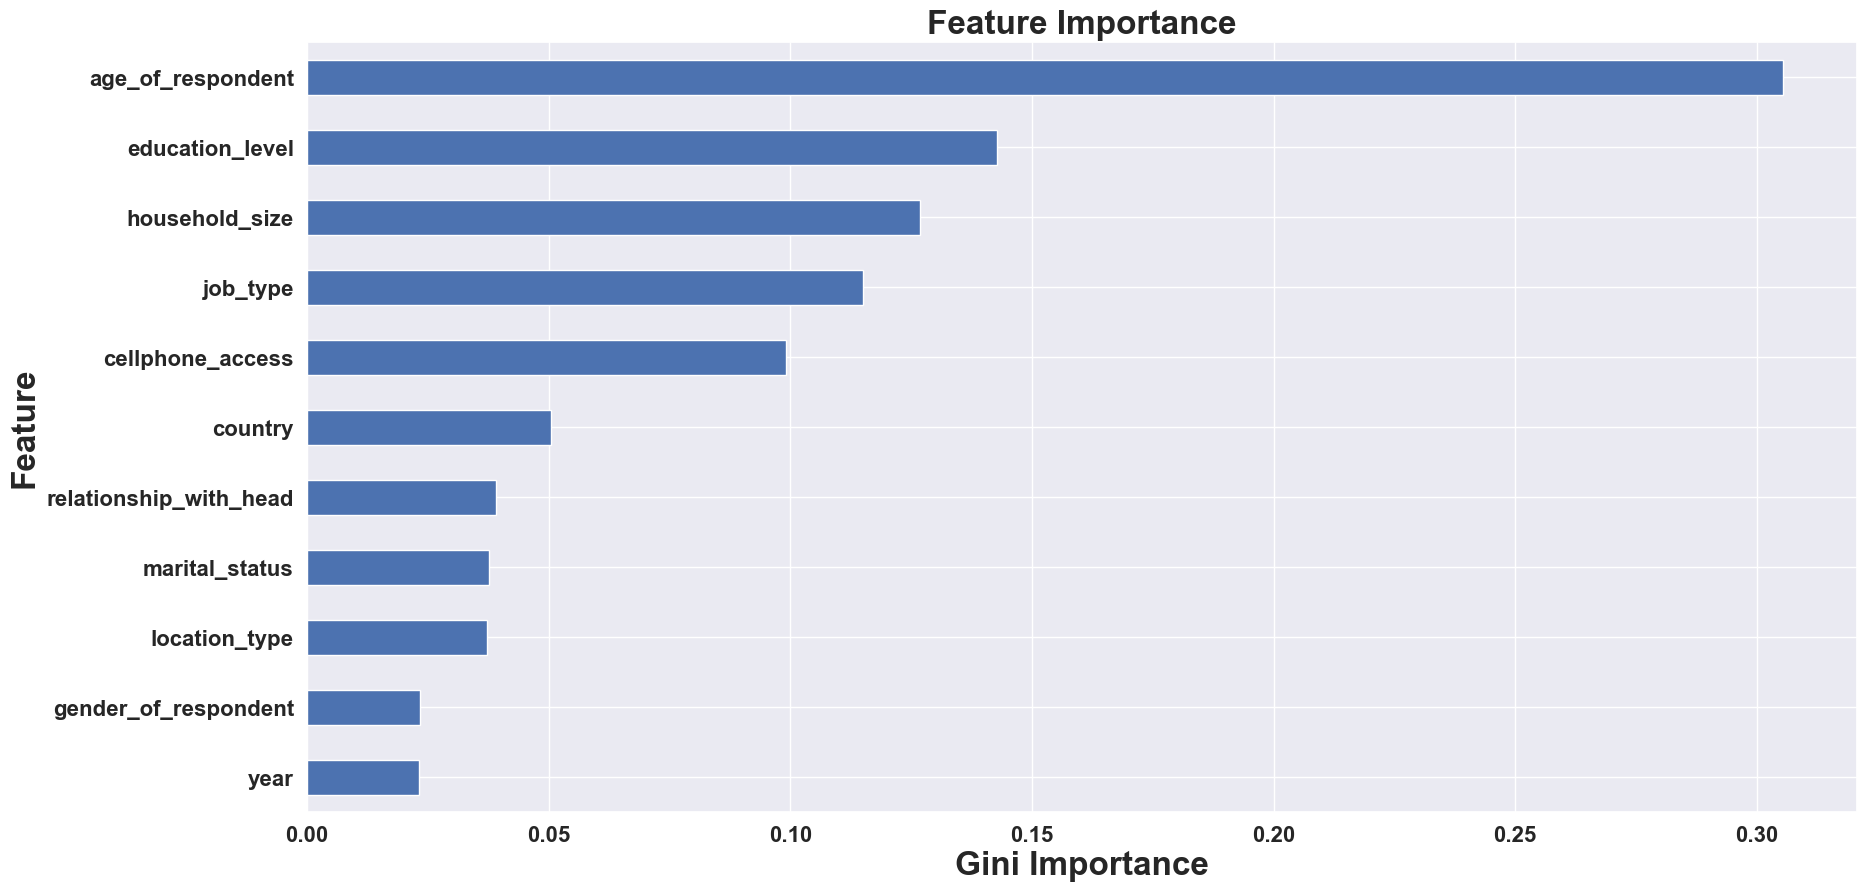

In [20]:
# Extract importances from model
importances = over_sampled_model.named_steps['randomforestclassifier'].feature_importances_

encoder = over_sampled_model.named_steps['onehotencoder']
encoded_feature_names = encoder.get_feature_names_out(X_test.columns)
original_features = X_test.columns.to_list()

feature_importance_dict = {}
for feature in original_features:
    feature_importance_dict[feature] = 0

# Accumulate importances for original features by summing up one-hot encoded columns
for feature, importance in zip(encoded_feature_names, importances):
    # Split the feature by '_'
    parts = feature.split('_')
    
    # Check if the last part is a number (indicating it's one-hot encoded)
    if parts[-1].isdigit():
        # Drop the last part (the number) and rejoin the remaining parts
        base_feature = '_'.join(parts[:-1])
    else:
        # If the feature doesn't have a numeric part, keep it as is
        base_feature = feature
    
    # Add the importance to the base feature
    if base_feature in feature_importance_dict:
        feature_importance_dict[base_feature] += importance
    else:
        print(f"Warning: {base_feature} not found in original features")

# Create a series with original features and cumulative importances
feat_imp = pd.Series(feature_importance_dict).sort_values()

# Plot 10 most important features
sns.set()
plt.figure(figsize = (20, 10))
feat_imp.plot(kind = 'barh')
plt.xlabel("Gini Importance", fontsize=24, weight="bold")
plt.ylabel("Feature", fontsize=24, weight="bold")
plt.title("Feature Importance", fontsize=24, weight="bold")
plt.yticks(weight='bold', fontsize=16) 
plt.xticks(weight='bold', fontsize=16);